In [123]:
import numpy as np
import json
from collections import defaultdict, Counter
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

In [2]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'

# Community semantics over time

In [74]:
EMBED_PATH = LOGS + 'semantics_mano/embed/'

In [76]:
bert_mean = np.load(LOGS + 'wikipedia/mean_BERT.npy')
bert_std = np.load(LOGS + 'wikipedia/std_BERT.npy')

In [77]:
vocab_order = []
full_reps = []
years = range(2008, 2014)
for y in years: 
    with open(EMBED_PATH + 'reddit_' + str(y) + '.json', 'r') as infile: 
        d = json.load(infile) # { term_category_year : vector }
    for key in sorted(d.keys()): 
        parts = key.split('_')
        term = parts[0]
        cat_year = '_'.join(parts[1:3])
        standard_vec = (np.array(d[key]) - bert_mean) / bert_std
        full_reps.append(standard_vec)
        vocab_order.append(key)
full_reps = np.array(full_reps)

In [78]:
twod_reps = TSNE(n_components=2, random_state=32).fit_transform(full_reps)

/mnt/data0/lucy/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/mnt/data0/lucy/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [79]:
full_dict = defaultdict(dict)
for i, key in enumerate(vocab_order): 
    parts = key.split('_')
    term = parts[0]
    cat_year = '_'.join(parts[1:3])
    full_dict[cat_year][term] = twod_reps[i]

In [80]:
with open(LOGS + 'gram_counts/combined_catyear_word_count.json', 'r') as infile: 
    catyear_word_count = json.load(infile)
print(full_dict.keys())
print('---------')
print(catyear_word_count.keys())
cats = ['TRP', 'MRA', 'PUA', 'Incels', 'MGTOW', 'Femcels', 'FDS']

dict_keys(['MRA_2008', 'PUA_2008', 'MRA_2009', 'PUA_2009', 'MRA_2010', 'PUA_2010', 'Incels_2010', 'Incels_2011', 'PUA_2011', 'MRA_2011', 'Incels_2012', 'PUA_2012', 'MRA_2012', 'TRP_2012', 'MGTOW_2012'])
---------
dict_keys(['FORUM_avfm_2017', 'FORUM_avfm_2015', 'FORUM_avfm_2014', 'FORUM_avfm_2016', 'FORUM_avfm_2013', 'FORUM_avfm_2019', 'FORUM_avfm_2012', 'FORUM_avfm_2018', 'FORUM_rooshv_2013', 'FORUM_rooshv_2019', 'FORUM_rooshv_2014', 'FORUM_rooshv_2010', 'FORUM_rooshv_2017', 'FORUM_rooshv_2018', 'FORUM_rooshv_2015', 'FORUM_rooshv_2016', 'FORUM_rooshv_2012', 'FORUM_rooshv_2011', 'FORUM_rooshv_2009', 'FORUM_rooshv_None', 'FORUM_rooshv_2008', 'FORUM_pua_forum_2012', 'FORUM_pua_forum_2011', 'FORUM_pua_forum_2008', 'FORUM_pua_forum_2014', 'FORUM_pua_forum_2009', 'FORUM_pua_forum_2018', 'FORUM_pua_forum_2016', 'FORUM_pua_forum_2007', 'FORUM_pua_forum_2019', 'FORUM_pua_forum_2006', 'FORUM_pua_forum_2013', 'FORUM_pua_forum_2017', 'FORUM_pua_forum_2010', 'FORUM_pua_forum_2015', 'FORUM_mgtow_20

In [133]:
def plot_embeddings_over_time(cat): 
    for year_num in years: 
        cat_year = cat + '_' + str(year_num)
        if cat_year not in full_dict: continue
        term_reps = full_dict[cat_year]
        x = []
        y = []
        z = []
        for term in term_reps: 
            x.append(term_reps[term][0])
            y.append(term_reps[term][1]) 
            z.append(catyear_word_count[cat_year][term])
        area = [count*0.1 for count in z]  
        sc = plt.scatter(x, y, alpha=0.3, c=z, cmap='plasma', marker='.', s=area)
        plt.colorbar(sc)
        plt.title(cat_year)
        plt.show()
def plot_one_term(term): 
    x = []
    y = []
    z = []
    labels = []
    for cat in cats: 
        for year_num in years: 
            cat_year = cat + '_' + str(year_num)
            if cat_year not in full_dict: continue
            term_reps = full_dict[cat_year]
            if term not in term_reps: continue
            x.append(term_reps[term][0])
            y.append(term_reps[term][1]) 
            z.append(catyear_word_count[cat_year][term])
            labels.append(cat_year)
    area = [count*0.5 for count in z]  
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sc = ax[0].scatter(x, y, alpha=0.3, c=z, cmap='plasma', marker='.', s=area)
    texts = [ax[0].text(x[i], y[i], labels[i], ha='center', va='center') for i in range(len(x))]
    adjust_text(texts, ax=ax[0])
    sc = ax[1].scatter(x, y, alpha=0.3, c=z, cmap='plasma', marker='.', s=area)
    ax[1].set_ylim([-80, 80])
    ax[1].set_xlim([-75, 75])
    plt.colorbar(sc)
    plt.title(term)
    plt.show()

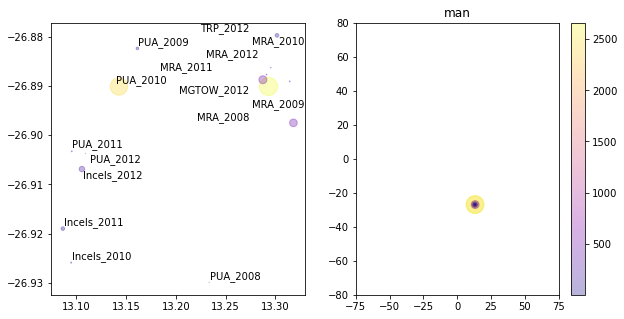

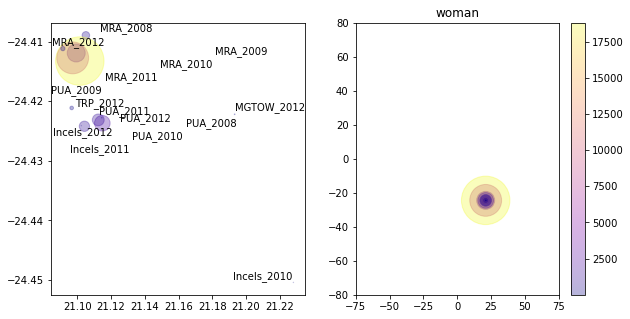

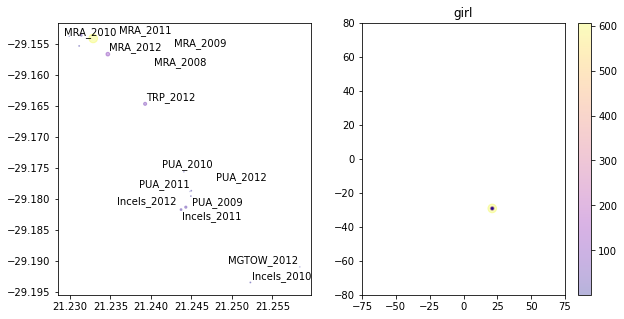

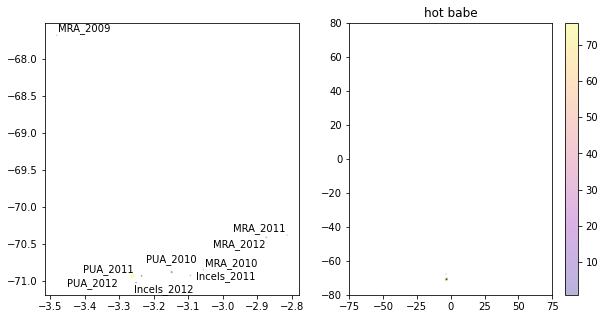

In [134]:
plot_one_term('man')
plot_one_term('woman')
plot_one_term('girl')
plot_one_term('hot babe')

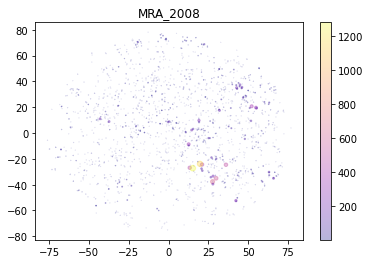

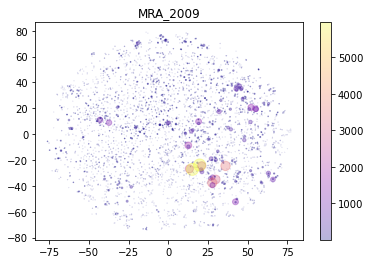

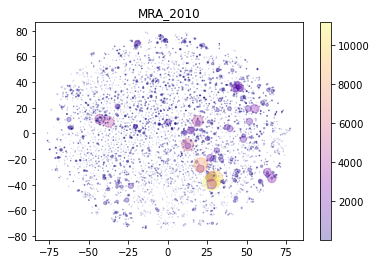

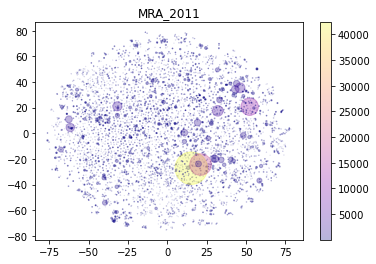

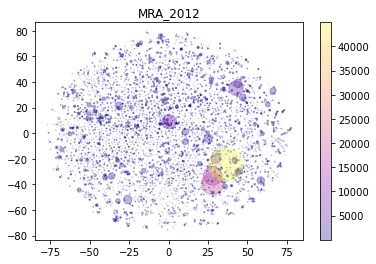

In [82]:
# TODO: color points by frequency in that community in that year 
plot_embeddings_over_time('MRA')

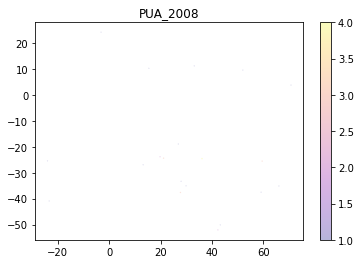

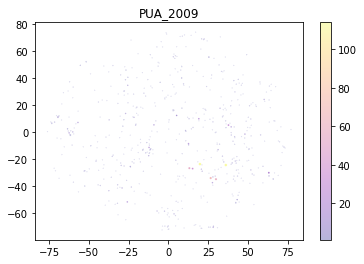

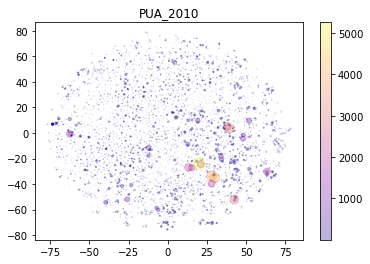

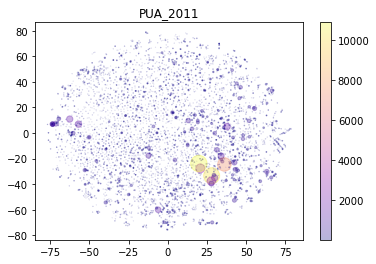

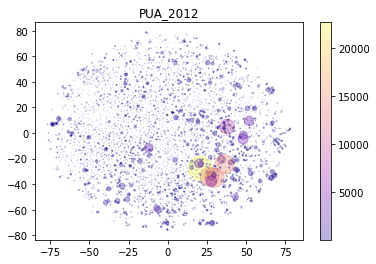

In [83]:
plot_embeddings_over_time('PUA')

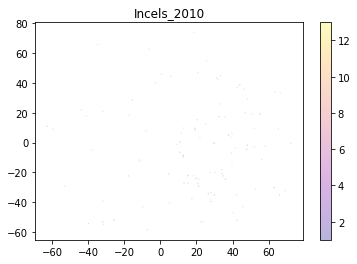

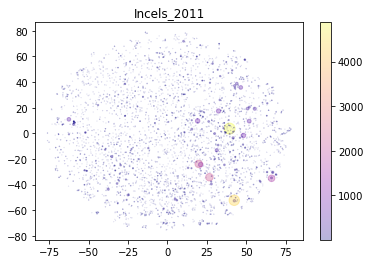

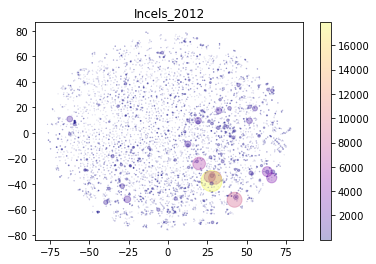

In [84]:
plot_embeddings_over_time('Incels')